In [1]:
! pip install --user scipy wordcloud nltk seaborn textblob

## Summary of the Program
Library Installation:
>Installed required libraries: scipy, wordcloud, nltk, seaborn, and textblob.

Data Loading and Exploration:
>Loaded tweet data from a CSV file using Pandas.
>Explored dataset information, including column names and data types.

Text Preprocessing:
>Converted tweets to lowercase.
>Removed Twitter usernames, URLs, and special characters.
>Handled emojis and contractions.
>Tokenized and applied stemming using NLTK's Porter Stemmer.
>Removed stop words.

Data Visualization:
>Created a pie chart to visualize the distribution of positive and negative sentiments.
>Generated word clouds for positive and negative sentiments to highlight frequently used words.

Feature Extraction:
>Used the bag-of-words approach to convert text into numerical vectors.
>Employed CountVectorizer from scikit-learn to create a matrix of word occurrences.

Model Training:
>Split the dataset into training and testing sets.
>Trained a Multinomial Naive Bayes classifier on the training data.

Model Evaluation:
>Assessed the model's performance on the testing set.

Model Saving:
>Saved the trained Naive Bayes model and CountVectorizer using joblib.

Model Loading and Prediction:
>Loaded the saved model and CountVectorizer.
>|Demonstrated how to make predictions on new preprocessed data.



In [2]:
import numpy as np
import pandas as pd
import json, nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
# nltk.download('wordnet')   # for Lemmatization


In [3]:
total_data=pd.read_csv('train (1).csv',encoding='ISO-8859-1')

In [4]:
total_data.head(5)

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


In [5]:
tweet = total_data.columns.values[2]
sentiment = total_data.columns.values[1]
tweet,sentiment

('SentimentText', 'Sentiment')

In [6]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99989 entries, 0 to 99988
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ItemID         99989 non-null  int64 
 1   Sentiment      99989 non-null  int64 
 2   SentimentText  99989 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


# Preprocessiong

# Convert every tweets to lower case
Remove Twitter username
Remove punctuations, numbers and special characters
Convert more than 2 letter repetitions to 2 letter ( example (wooooooow --> woow))
Remove extra spaces
Remove URLs
Emoji analysis
Handle contractions words
" can't " >> " can not "
" won't " >> " will not "
" should't " >> " should not "
Tokenization
(Optional) Remove Stop words
(Optional) Text Normalization (Stemming / Lemmatization)

In [7]:
import re
def emoji(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' positiveemoji ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', tweet)
    return tweet

In [8]:
import re

def process_tweet(tweet):
    tweet = tweet.lower()                                             # Lowercases the string
    tweet = re.sub('@[^\s]+', '', tweet)                              # Removes usernames
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet)   # Remove URLs
    tweet = re.sub(r"\d+", " ", str(tweet))                           # Removes all digits
    tweet = re.sub('&quot;'," ", tweet)                               # Remove (&quot;) 
    tweet = emoji(tweet)                                              # Replaces Emojis
    tweet = re.sub(r"\b[a-zA-Z]\b", "", str(tweet))                   # Removes all single characters
    tweet = re.sub(r"[^\w\s]", " ", str(tweet))                       # Removes all punctuations
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)                         # Convert more than 2 letter repetitions to 2 letter
    tweet = re.sub(r"\s+", " ", str(tweet))                           # Replaces double spaces with single space    
    return tweet

In [9]:
total_data['processed_tweet'] = np.vectorize(process_tweet)(total_data[tweet])
# or total_data['processed_tweet'] = np.vectorize(process_tweet)(total_data['SentimentText'])

In [10]:
total_data['Sentiment'].nunique()

2

In [11]:
total_data.head(10)

,ItemID,Sentiment,SentimentText,processed_tweet
0,1,0,is so sad for my APL frie...,is so sad for my apl friend
1,2,0,I missed the New Moon trail...,missed the new moon trailer
2,3,1,omg its already 7:30 :O,omg its already
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...,omgaga im soo im gunna cry ve been at this de...
4,5,0,i think mi bf is cheating on me!!! ...,think mi bf is cheating on me t_t
5,6,0,or i just worry too much?,or just worry too much
6,7,1,Juuuuuuuuuuuuuuuuussssst Chillin!!,juusst chillin
7,8,0,Sunny Again Work Tomorrow :-| ...,sunny again work tomorrow negetiveemoji tv to...
8,9,1,handed in my uniform today . i miss you ...,handed in my uniform today miss you already
9,10,1,hmmmm.... i wonder how she my number @-),hmm wonder how she my number


In [12]:
tokenized_tweet = total_data['processed_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0                  [is, so, sad, for, my, apl, friend]
1                    [missed, the, new, moon, trailer]
2                                  [omg, its, already]
3    [omgaga, im, soo, im, gunna, cry, ve, been, at...
4           [think, mi, bf, is, cheating, on, me, t_t]
Name: processed_tweet, dtype: object

In [13]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_tweet.head()

0                  [is, so, sad, for, my, apl, friend]
1                      [miss, the, new, moon, trailer]
2                                   [omg, it, alreadi]
3    [omgaga, im, soo, im, gunna, cri, ve, been, at...
4              [think, mi, bf, is, cheat, on, me, t_t]
Name: processed_tweet, dtype: object

In [14]:
tokenized_tweet

0                      [is, so, sad, for, my, apl, friend]
1                          [miss, the, new, moon, trailer]
2                                       [omg, it, alreadi]
3        [omgaga, im, soo, im, gunna, cri, ve, been, at...
4                  [think, mi, bf, is, cheat, on, me, t_t]
                               ...                        
99984    [seem, like, repeat, problem, hope, you, re, a...
99985    [arr, we, both, repli, to, each, other, over, ...
99986                                    [ya, thought, so]
99987        [ye, ye, glad, you, had, more, fun, with, me]
99988                                  [haha, ye, you, do]
Name: processed_tweet, Length: 99989, dtype: object

In [15]:
stop_words = {"i", "me", "my", "myself", "we", "our", "ours", "ourselves",
            "you", "your", "yours", "yourself", "yourselves", "he", "him",
            "his", "himself", "she", "her", "hers", "herself", "it", "its",
            "itself", "they", "them", "their", "theirs", "themselves", "what",
            "which", "who", "whom", "this", "that", "these", "those", "am", "is",
            "are", "was", "were", "be", "been", "being", "have", "has", "had",
            "having", "do", "does", "did", "doing", "a", "an", "the", "and",
            "but", "if", "or", "because", "as", "until", "while", "of", "at",
            "by", "for", "with", "about", "against", "between", "into", "through",
            "during", "before", "after", "above", "below", "to", "from", "up",
            "down", "in", "out", "on", "off", "over", "under", "again", "further",
            "then", "once", "here", "there", "when", "where", "why", "how", "all",
            "any", "both", "each", "few", "more", "most", "other", "some", "such",
            "only", "own", "same", "so", "than", "too", "very",
            "can", "will", "just", "should", "now"}

In [16]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))
stop_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [17]:
total_data.head()

,ItemID,Sentiment,SentimentText,processed_tweet
0,1,0,is so sad for my APL frie...,is so sad for my apl friend
1,2,0,I missed the New Moon trail...,missed the new moon trailer
2,3,1,omg its already 7:30 :O,omg its already
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...,omgaga im soo im gunna cry ve been at this de...
4,5,0,i think mi bf is cheating on me!!! ...,think mi bf is cheating on me t_t


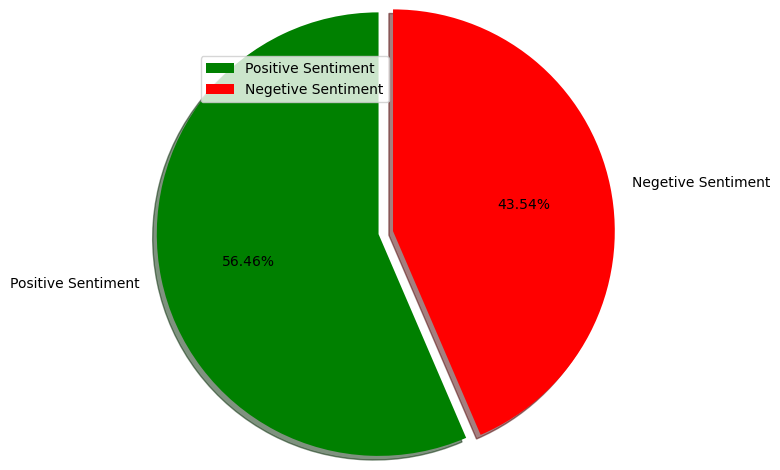

In [18]:
sentiments = ['Positive Sentiment', 'Negetive Sentiment'] 
slices = [(total_data[sentiment] != 0).sum(), (total_data[sentiment] == 0).sum()] 
colors = ['g', 'r'] 
plt.pie(slices, labels = sentiments, colors=colors, startangle=90, shadow = True,
        explode = (0, 0.1), radius = 1.5, autopct = '%1.2f%%') 
plt.legend()
plt.show()

In [19]:
slices

[56457, 43532]

<Figure size 3840x2880 with 0 Axes>

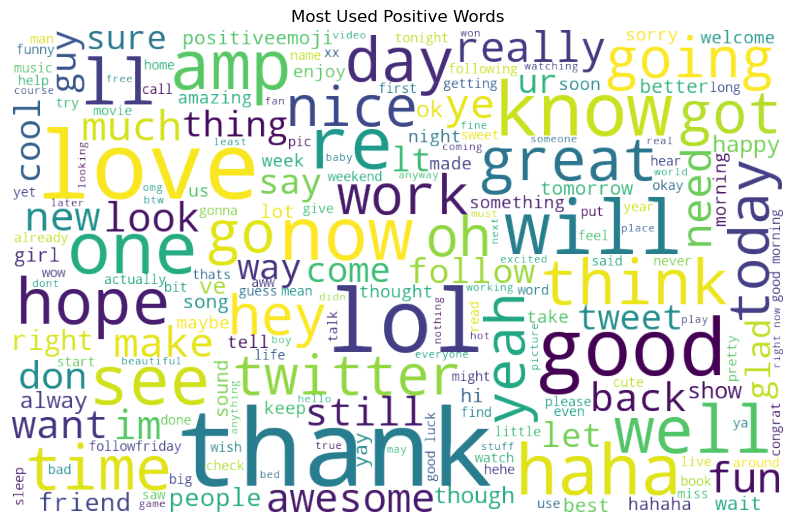

In [20]:
positive_words =' '.join([text for text in total_data['processed_tweet'][total_data[sentiment] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21,
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(positive_words)
plt.figure(dpi=600)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Used Positive Words")
# plt.savefig('assets/positive_words.png')
plt.show()


<Figure size 3840x2880 with 0 Axes>

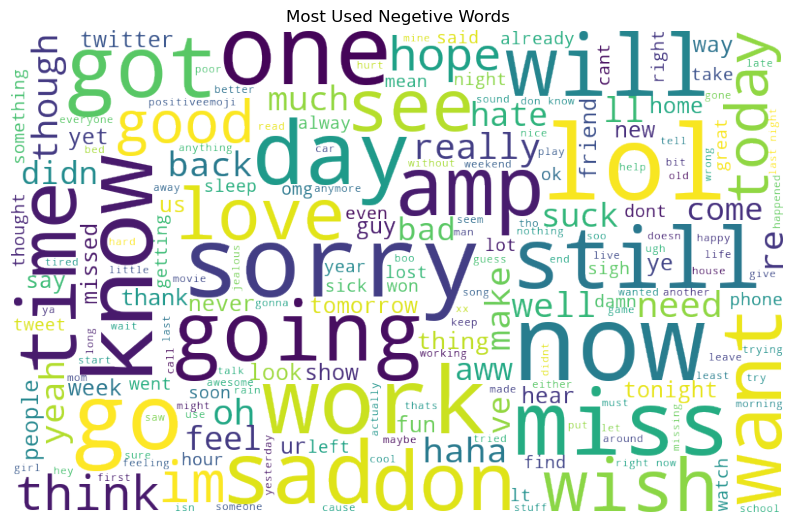

In [21]:
negetive_words =' '.join([text for text in total_data['processed_tweet'][total_data[sentiment] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, 
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(negetive_words)
plt.figure(dpi=600)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Used Negetive Words")
# plt.savefig('assets/negetive_words.png')
plt.show()

In [22]:
#bag of words

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(ngram_range=(1,1))    # Unigram
final_vectorized_data = count_vectorizer.fit_transform(total_data['processed_tweet'])  
final_vectorized_data

<99989x48958 sparse matrix of type '<class 'numpy.int64'>'
	with 1079851 stored elements in Compressed Sparse Row format>

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_vectorized_data, total_data[sentiment],
                                                    test_size=0.2, random_state=69)

In [25]:
print("X_train_shape : ",X_train.shape)
print("X_test_shape : ",X_test.shape)
print("y_train_shape : ",y_train.shape)
print("y_test_shape : ",y_test.shape)

X_train_shape :  (79991, 48958)
X_test_shape :  (19998, 48958)
y_train_shape :  (79991,)
y_test_shape :  (19998,)


In [27]:
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes Classifier

model_naive = MultinomialNB().fit(X_train, y_train) 
predicted_naive = model_naive.predict(X_test)

In [44]:
import joblib

# Save the model to a file
joblib.dump(model_naive, r"E:\Data Science class\NLP\NLPsentiment_model.pkl")

['E:\\Data Science class\\NLP\\NLPsentiment_model.pkl']

In [43]:
loaded_model = joblib.load(r"E:\Data Science class\NLP\NLPsentiment_model.pkl")

In [34]:
import joblib

# Load the trained model
# loaded_model = joblib.load(r"C:\Users\ASUS\Downloads\NLP\NLPsentiment_model.pkl")

# New data
new_data = ["he killing some1"]   ## this is the input text which we will give to our model

# Preprocess the new data (make sure you have the same preprocessing steps as during training)
new_data_processed = np.vectorize(process_tweet)(new_data)

In [35]:
new_data_processed

array(['he killing some '], dtype='<U16')

In [36]:
# Vectorize the new data using the same CountVectorizer
new_data_vectorized = count_vectorizer.transform(new_data_processed)

In [37]:
new_data_vectorized

<1x48958 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [38]:
# Predict sentiment
predictions = loaded_model.predict(new_data_vectorized)

print(predictions)

[0]


In [40]:
import joblib

# Save the model to a file
joblib.dump(count_vectorizer, r"E:\Data Science class\NLP\countvectorizer.pkl")

['E:\\Data Science class\\NLP\\countvectorizer.pkl']